# <center> Parallelism with Tensorflow Dataset built with `from_generator()` </center>

The optimal way of building datapipes in Tensorflow is to use the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). While there might be a learning curve in using it, it provides efficient datapiping. A lot of member functions of the Dataset class natively implement parallelism, which can leverage the whole power of your multi-core system. For instance, several threads can read in parallel files from the local storage and/or some network attached storage, alleviating a possible I/O bottleneck.

One way of building a Tensorflow Dataset is to use `tf.data.Dataset.from_generator()`. Unfortunately, there is no built-in way of including some sort of parallelism. Fortunately, there are some tricks one could use to circumvent this! This is the goal of this notebook.

In [1]:
import time
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
# Create some dummy dataset
np.random.seed(0)
n_samples = 300
n_features = 4
data = np.random.rand(n_samples, (n_features + 1))

cols = ["x%d"%i for i in range(n_features)]
cols += ["y"]

print("The number of samples is", len(data))
data = pd.DataFrame(data, columns=cols)
data.head()

The number of samples is 300


,x0,x1,x2,x3,y
0,0.548814,0.715189,0.602763,0.544883,0.423655
1,0.645894,0.437587,0.891773,0.963663,0.383442
2,0.791725,0.528895,0.568045,0.925597,0.071036
3,0.087129,0.020218,0.832620,0.778157,0.870012
4,0.978618,0.799159,0.461479,0.780529,0.118274


The dataset we are working with contains 4 features "x0", "x1", "x2 and "x3", and one label "y".

### The single threaded solution

We will first build a single threaded tf.data.Dataset. This will also allow us to set the baseline so that we can later see if the multi-threaded solution is worth it (spoiler alert: IT IS!) 

In [3]:
class SimpleGenerator:
    def __init__(self, df: pd.DataFrame, sleep: float = 0.05):
        # Copy the pd.DataFrame to store it internally. This is the safe way of using generator.
        # If you don't copy it and modify it on the fly, while the generator is still running, 
        # it might do some nasty things.
        self._df = df.copy()
        
        # This is to simulate some overhead, e.g. I/O from disk or network or some pre-processing.
        self._sleep = sleep
        
    def __call__(self):
        # Loop over the whole dataset
        for i, row in self._df.iterrows():
            
            # Simulate the overhead
            time.sleep(self._sleep)
            
            tf_index = tf.convert_to_tensor(i, dtype=tf.uint32)
            
            tf_x = tf.convert_to_tensor(row[["x0", "x1", "x2", "x3"]], dtype=tf.float32)
            
            tf_y = tf.convert_to_tensor(row["y"], dtype=tf.float32)
            
            yield tf_index, tf_x, tf_y
            
            
gen = SimpleGenerator(data, sleep=0.05)

out_sign = (tf.TensorSpec(shape=(), dtype=tf.uint32),
            tf.TensorSpec(shape=(4,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32))
                

ds = tf.data.Dataset.from_generator(SimpleGenerator(data, sleep=0.05),
                                    output_signature=out_sign)


def evaluate_dataset(ds: tf.data.Dataset):
    t = time.time()
    time_vec = []
    for i in ds:
        if i[0].numpy() % 100 == 0:
            print(i[0].numpy())
        time_vec.append(time.time() - t)
        t = time.time()
        
    return pd.Series(time_vec)


t = evaluate_dataset(ds)

0
100
200


Total time = 16.60 seconds
Per iteration statistics:
	Mean   = 55.33 ms
	Std    = 5.49 ms


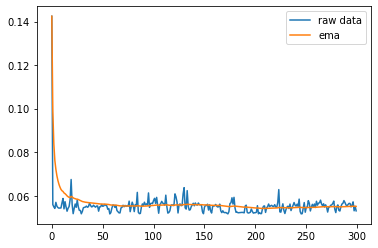

In [4]:
def show_statistics(t: pd.Series):
    print("Total time = %.2f seconds" % t.sum())
    print("Per iteration statistics:")
    print("\tMean   = %.2f ms" % (t.mean() * 1e3))
    print("\tStd    = %.2f ms" % (t.std() * 1e3))

    plt.plot(t, label = "raw data") 
    plt.plot(t.ewm(span=100).mean(), label="ema")
    plt.legend()
    
    
show_statistics(t)

Essentially, each iteration takes \~55 ms (~0.05 s), which is the overhead time of our generator. Our application is completelly "generator bottlenecked", which is understandable as our loop (see `evaluate_dataset`) does ... nothing ! 

Let us try a parallel version then

In [5]:
# Simple generator
class ShardedGenerator:
    def __init__(self, df: pd.DataFrame, sleep: float = 1.5, n_shards: int = None):
        
        self._df = df.copy()
        
        self._sleep = sleep
        
        self._n_shards = n_shards
        if self._n_shards is None:
            self._n_shards = cpu_count()
        
        
    def __call__(self, n):
        for en, (i, row) in enumerate(self._df.iterrows()):
            if en % n_shards != n:
                continue
                
            # Simulate the overhead
            time.sleep(self._sleep)
            
            tf_index = tf.convert_to_tensor(i, dtype=tf.uint32)
            
            tf_x = tf.convert_to_tensor(row[["x0", "x1", "x2", "x3"]], dtype=tf.float32)
            
            tf_y = tf.convert_to_tensor(row["y"], dtype=tf.float32)
            
            yield tf_index, tf_x, tf_y

# Define the number of shards. It should be the number of parallel calls you wanna make             
n_shards = 4

gen = ShardedGenerator(data, sleep=0.05, n_shards=n_shards)

out_sign = (tf.TensorSpec(shape=(), dtype=tf.uint32),
            tf.TensorSpec(shape=(4,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32))
             

# This first dataset is just a vector that looks like [0, 1, 2, 3] (here n_shards=4).
ds = tf.data.Dataset.from_tensor_slices(np.arange(n_shards))

# We interleave the Dataset "[0, 1, 2, 3]", each element generate a new Dataset ! THIS is the trick which
# leads to parallelism
ds = ds.interleave(lambda x: tf.data.Dataset.from_generator(gen, output_signature=out_sign, args=(x,)),
                   cycle_length=n_shards,
                   block_length=1,
                   num_parallel_calls=n_shards,
                   deterministic=True)

t = evaluate_dataset(ds)

0
100
200


Total time = 4.40 seconds
Per iteration statistics:
	Mean   = 14.67 ms
	Std    = 21.59 ms


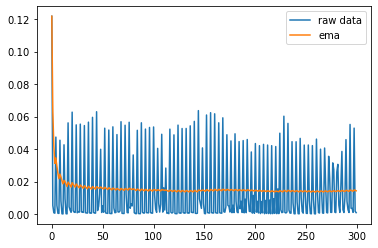

In [6]:
show_statistics(t)

We see here that we went from 16 seconds to 4 seconds !!! This is a huge improvement. Essentially, we reduced the running time by a factor 4 (the number of cpu cores on my machine, you can play with the `n_shards` parameter).

In general, the loop you will be running contains time consuming operations, e.g. training a neural network. If we define `t_iter` the time it takes to run one loop independently of the generator (i.e. training on one batch), `n_threads` the number of threads involved in the generator and `t_gen` the time of one thread to execute one iteration of the generator, then your loop is NOT generator bottlenecked if: `t_iter * n_threads > t_gen`.

You might also benefit from the `deterministic=False` option in the `interleave` stage. This will most probably be application dependent though.

0
100
200
Total time = 4.38 seconds
Per iteration statistics:
	Mean   = 14.59 ms
	Std    = 12.73 ms


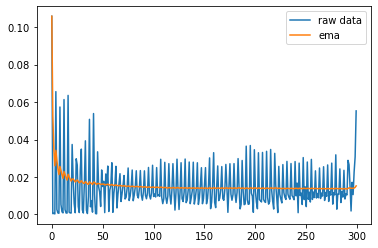

In [7]:
### Test with more than cpu_count() generators

n_shards = 6

gen = ShardedGenerator(data, sleep=0.05, n_shards=n_shards)

out_sign = (tf.TensorSpec(shape=(), dtype=tf.uint32),
            tf.TensorSpec(shape=(4,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32))
             

# This first dataset is just a vector that looks like [0, 1, 2, 3] (here n_shards=4).
ds = tf.data.Dataset.from_tensor_slices(np.arange(n_shards))

# We interleave the Dataset "[0, 1, 2, 3]", each element generate a new Dataset ! THIS is the trick which
# leads to parallelism
ds = ds.interleave(lambda x: tf.data.Dataset.from_generator(gen, output_signature=out_sign, args=(x,)),
                   cycle_length=n_shards,
                   block_length=1,
                   num_parallel_calls=n_shards,
                   deterministic=False)

ds = ds.prefetch(20)

t = evaluate_dataset(ds)
show_statistics(t)